In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import bootstrap
from scipy.stats import chi2
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import pydotplus

tqdm.pandas()

In [ ]:
def exponential_interpolate(df):
    for c in df.columns:
        numeric=False
        try: df[c].astype(float); numeric=True
        except: pass

        if numeric:
            series = np.log(df[c].astype(float))
            series = series.interpolate('linear')
            series = np.exp(series)
            df[c] = series
    return df

def null_z(df,groupby,col,z):
    numeric=False; exceptions=[]
    try: df[col].astype(float); numeric=True
    except: pass

    if numeric:
        pct_change = df.dropna(subset=[col])
        pct_change = pct_change.groupby(groupby)[col].pct_change()
        pct_change = (pct_change-pct_change.mean())/pct_change.std()
        exceptions = df.loc[pct_change[abs(pct_change)>z].index, col]
        df.loc[exceptions.index, col] = np.nan
        df[col] = exponential_interpolate(df[[col]].copy())[col]
    return df[col], exceptions

#### Process Features (X variables)

In [ ]:
#read csvs
balance = pd.read_csv('data/us-balance-quarterly.csv', sep=';')
cashflow = pd.read_csv('data/us-cashflow-quarterly.csv', sep=';')
companies = pd.read_csv('data/us-companies.csv', sep=';')
income = pd.read_csv('data/us-income-quarterly.csv', sep=';')

#set indices
balance = balance.set_index(['SimFinId','Publish Date'])
cashflow = cashflow.set_index(['SimFinId','Publish Date'])
companies = companies.set_index(['SimFinId'])
income = income.set_index(['SimFinId','Publish Date'])

#drop metadata
drop = ['Ticker', 'Currency', 'Fiscal Year', 'Fiscal Period', 'Report Date','Restated Date', 'Shares (Basic)', 'Shares (Diluted)']
balance = balance.drop(columns=drop)
cashflow = cashflow.drop(columns=drop)
income = income.drop(columns=drop+['Depreciation & Amortization'])

#merge to dataframe
df = income.join(balance)
df = df.join(cashflow)
df = df.reset_index()

#heuristically drop multicolinearity columns
drop = [
    'Change in Accounts Payable',
    'Change in Inventories',
    'Change in Accounts Receivable',
    'Change in Other',
    'Pretax Income (Loss)',
    'Pretax Income (Loss), Adj.',
    'Total Assets',
    'Total Liabilities',
    'Total Liabilities & Equity',
    'Net Income (Common)',
    'Net Income/Starting Line',
    'Net Change in Long Term Investment',
    'Change in Fixed Assets & Intangibles',
    'Change in Working Capital',
    'Net Change in Cash',
    'Net Income',
    'Operating Income (Loss)',
    'Total Equity',
    'Total Noncurrent Assets',
    'Gross Profit',
    'Retained Earnings',
    'Net Cash from Investing Activities',
    'Net Cash from Operating Activities'
]
#df = df.drop(columns=drop)
df = df.set_index(['SimFinId','Publish Date'])



In [ ]:
def littles_mcar_test(df):
    # Compute the contingency table
    contingency_table = pd.crosstab(df.isnull().sum(axis=1), df.count(axis=1))
    # Perform the chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    # Determine if the data is MCAR based on the p-value
    is_mcar = p_value > 0.05

    return p_value, is_mcar

missing = pd.DataFrame({
    c:[1-len(df[c].dropna())/len(df[c])] for c in df.columns
    }).T\
    .rename(columns={0:'missing'})\
    .sort_values('missing',ascending=False)['missing']

for c in missing.index:
    df2 = df.copy()
    df2[c] = df2[c].fillna(0)

    # Perform Little's MCAR test on the DataFrame
    p_value, is_mcar = littles_mcar_test(df2)

    # Print the results
    print("Little's MCAR test p-value:", p_value)
    print("Is the data MCAR?", is_mcar)

Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR? False
Little's MCAR test p-value: 0.0
Is the data MCAR

In [ ]:
#Keep only companies with 5 years of data
#Exponentially Impute Missing Values

# #Maximize area of dataframe without nulls - maybe not a good idea because could be removing extrema accidentally
# max = (0,None)
# for c1 in tqdm(df.columns, desc='outer'):
#     try:
#         for c2 in df.columns:
#             size = df.drop(columns=[c2]).dropna().size
#             if size>max[0]: max=(size,c2)
#         df = df.drop(columns=[max[1]])
#     except: pass

df = df.fillna(0)

df = df.dropna()
df = df.reset_index()
df = df.set_index(['SimFinId'])
df = df[df.groupby('SimFinId')['Publish Date'].count()==20]
df = df.reset_index().set_index(['SimFinId','Publish Date'])

#Fix sign issues (negative revenue, etc.) which make calculating growth rates impossible (must be positive function)
# instead of abs, set to nan and then impute
pct = []
for c in df.columns:
    sign = 1-np.sign(df[c]).value_counts().iloc[0]/len(df)
    if sign<0.01 and len(df[df[c]==0])==0: df[c] = abs(df[c])
    else: df[c] = df[c].rank(pct=True); pct.append(c)

#identify outliers and replace with exponential interpolation
x_outliers = {}
for c in tqdm(df.columns):
    df[c], x_outliers[c] = null_z(df,'SimFinId',c,3)

/var/folders/qq/3nbq17090xb4knfwp5844qfh0000gn/T/ipykernel_32908/3276058567.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.groupby('SimFinId')['Publish Date'].count()==20]


  0%|          | 0/55 [00:00<?, ?it/s]

In [ ]:
x_outliers_df = pd.DataFrame(x_outliers)
for c in x_outliers_df.columns:
    zeros = len(x_outliers_df[x_outliers_df[c]==0])
    if zeros>0: print(f'{c}: {zeros}')

#### Process Response (Y variable)

In [ ]:
shareprice = pd.read_csv('data/us-shareprices-daily.csv', sep=';')
shareprice = shareprice.rename(columns={'Date':'Publish Date'})
shareprice = shareprice.set_index(['SimFinId','Publish Date'])
missing_prices = pd.DataFrame(columns=df.columns, index=df.index[~df.index.isin(shareprice.index)])
shareprice = pd.concat([shareprice,missing_prices])

#simple forward/backward fill for missing data
shareprice = shareprice.groupby('SimFinId').bfill()
shareprice = shareprice.groupby('SimFinId').ffill()

#reduce Y and X to common records
common = df.index[df.index.isin(shareprice.index)]
df = df.loc[common].sort_index()
shareprice = shareprice.loc[common].sort_index()

#identify outliers and replace with exponential interpolation
y_outliers = {}
for c in tqdm(shareprice.columns):
    shareprice[c], y_outliers[c] = null_z(shareprice,'SimFinId',c,3)

shareprice['MarketCap'] = shareprice['Shares Outstanding']*shareprice['Adj. Close']

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Run Value Regression

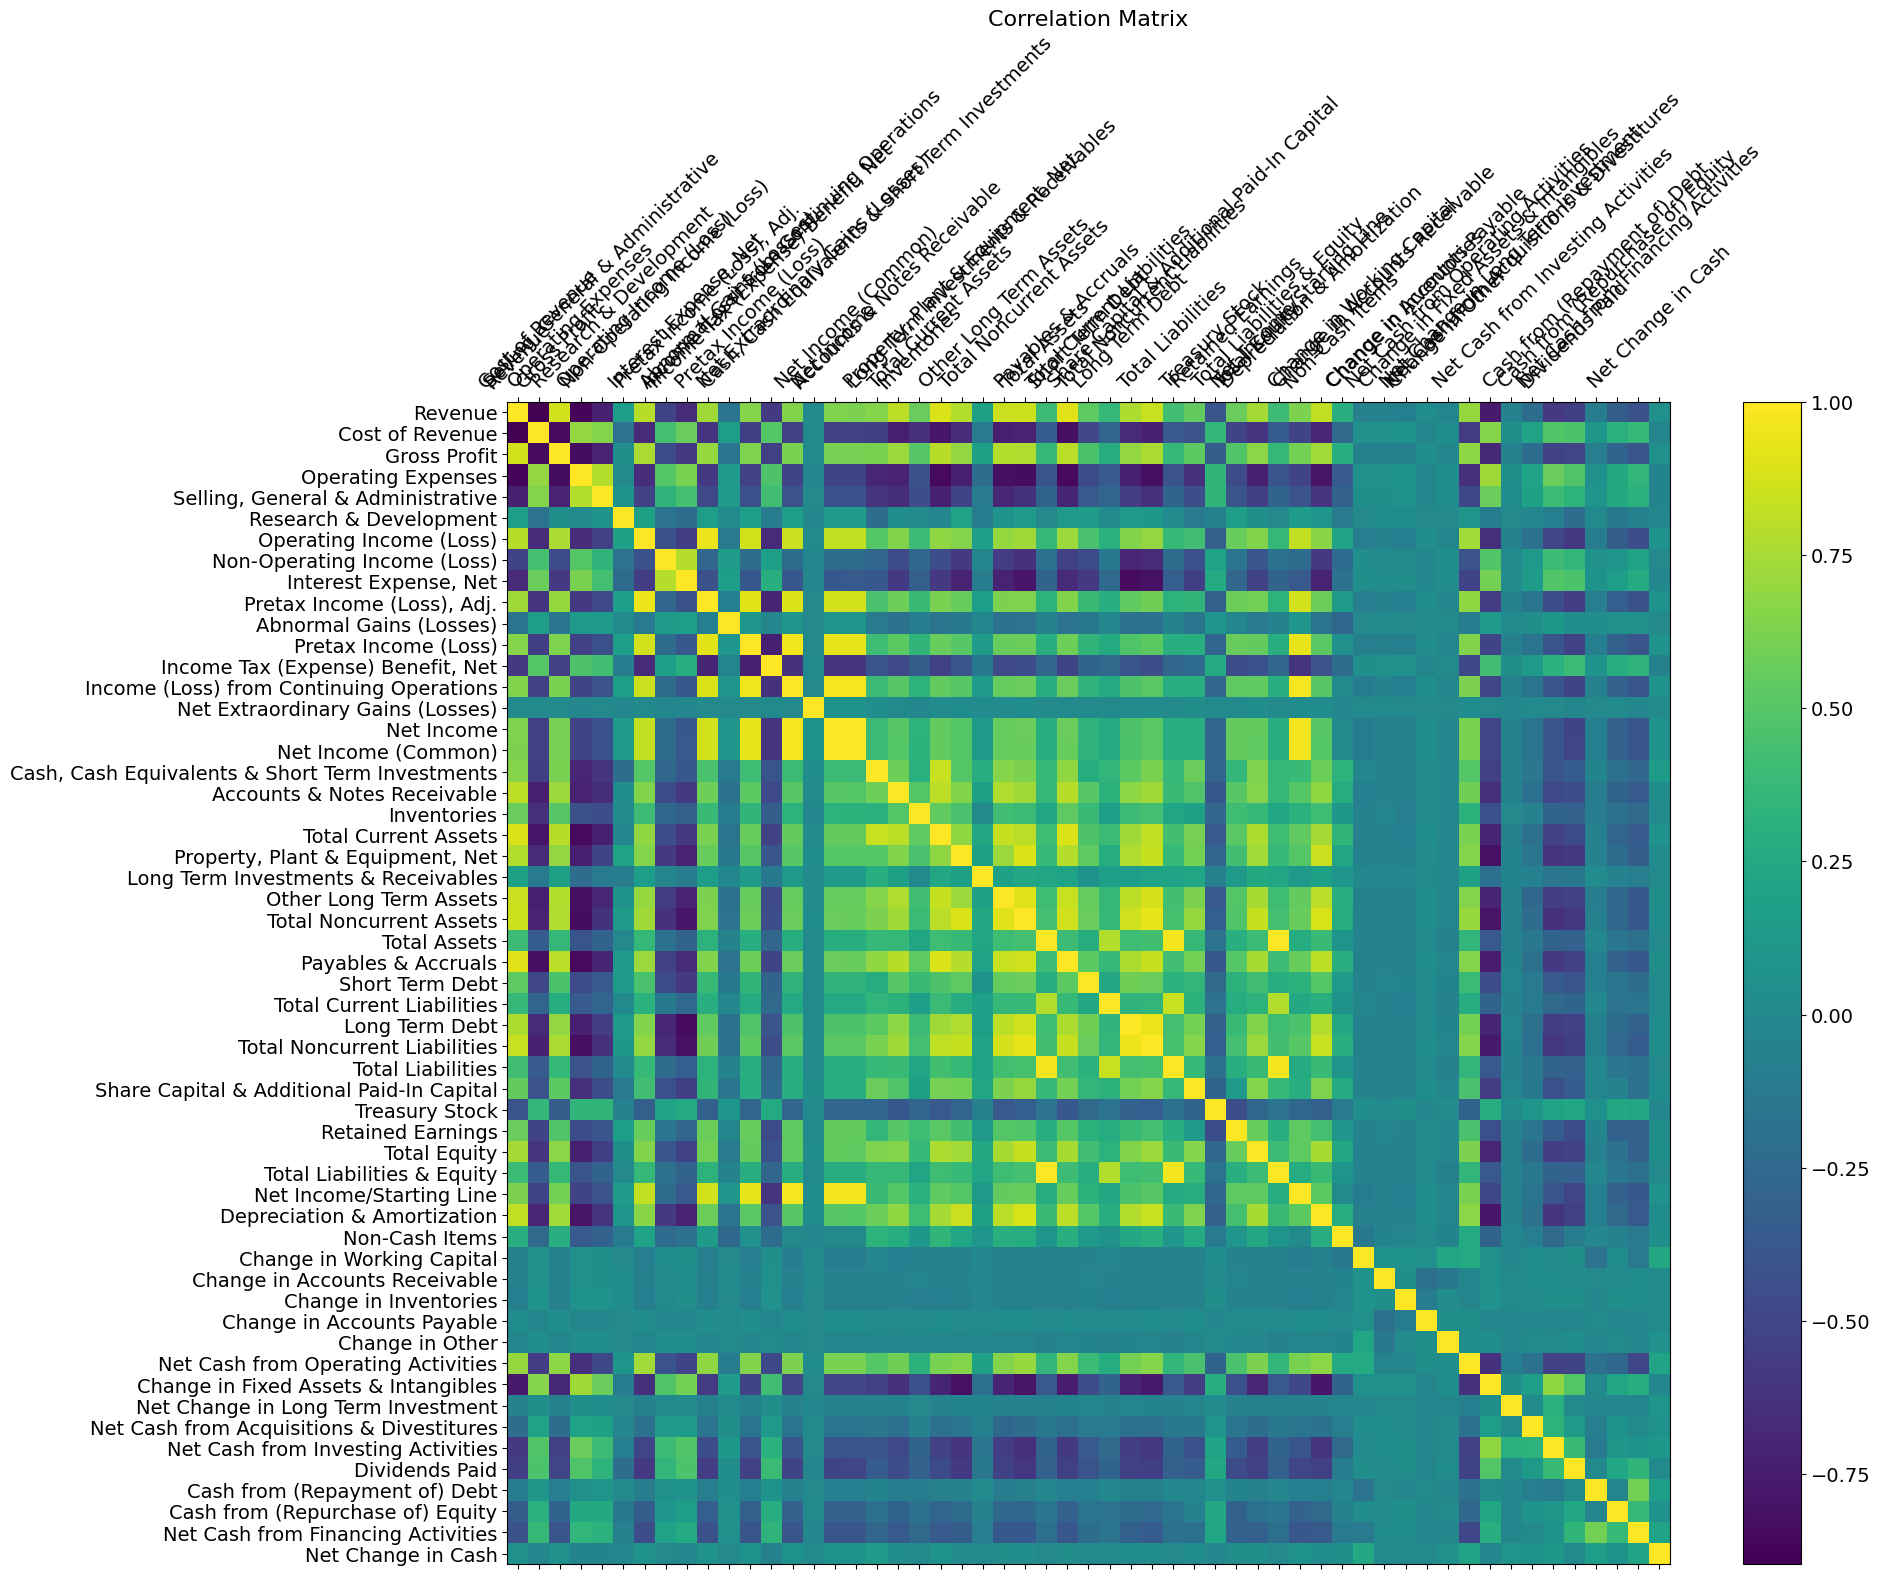

In [ ]:
X = df
y = shareprice['MarketCap']

X_train = X.groupby('SimFinId').head(-1)
X_test = X.groupby('SimFinId').tail(1)
y_train = np.array(y.groupby('SimFinId').head(-1)).reshape(-1,1)
y_test = np.array(y.groupby('SimFinId').tail(1)).reshape(-1,1)

#Plot correlation of X_Train
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.select_dtypes(['number']).shape[1]), X_train.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA

# Apply Yeo-Johnson transformation to the data and response
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = pt.fit_transform(X_train)
X_test = pt.fit_transform(X_test)
y_train = pt.fit_transform(y_train)
y_test = pt.fit_transform(y_test)

# Perform PCA on the transformed data
pca = PCA(n_components=X_train.shape[1])
X_train = pca.fit_transform(X_train)[:,pca.explained_variance_ratio_.cumsum()<0.95]
X_test = pca.fit_transform(X_test)[:,pca.explained_variance_ratio_.cumsum()<0.95]

In [ ]:
loadings = pd.DataFrame((pca.components_.T * np.sqrt(pca.explained_variance_))[:,pca.explained_variance_ratio_.cumsum()<0.95])
loadings.index = X.columns
loadings.columns = [f'PC{i+1}' for i in loadings.columns]
loadings.to_csv('loadings.csv')

In [ ]:
def model_stats(mdl, name):
    mdl.fit(X_train, y_train)

    # Get train error
    y_pred_train = mdl.predict(X_train)
    residuals_train = y_pred_train - y_train[:,0]

    # Get test error
    y_pred_test = mdl.predict(X_test)
    residuals_test = y_pred_test - y_test[:,0]

    # Get model statistics
    stats_train = pd.DataFrame({
        'mse': mean_squared_error(y_train[:,0], y_pred_train),
        'bias': np.mean(residuals_train),
        'variance': np.var(residuals_train),
        'skew': skew(residuals_train),
        'kurtosis': kurtosis(residuals_train)
    },index=[name+' (train)'])

    stats_test = pd.DataFrame({
        'mse': mean_squared_error(y_test[:,0], y_pred_test),
        'bias': np.mean(residuals_test),
        'variance': np.var(residuals_test),
        'skew': skew(residuals_test),
        'kurtosis': kurtosis(residuals_test)
    },index=[name+' (test)'])

    stats = pd.concat([stats_train, stats_test])

    return stats


from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [ ]:
linear = model_stats(name='Linear', mdl=SGDRegressor())

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
lasso = model_stats(name='Lasso', mdl=LassoCV(cv=5))

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
kernelsvm = model_stats(name='KernelSVM', mdl=SVR(kernel='rbf'))

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
quantile = model_stats(name='Quantile', mdl=QuantileRegressor(quantile=0.5, alpha=0, solver = "highs"))

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
randomForest = model_stats(name='Random Forest', mdl=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True, random_state=42))

/var/folders/qq/3nbq17090xb4knfwp5844qfh0000gn/T/ipykernel_32908/389464382.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mdl.fit(X_train, y_train)


In [ ]:
results = pd.concat([linear,lasso,kernelsvm,quantile,randomForest])
results['index'] = results.index.str.split('(').str[0]
results['train_test'] = results.index.str.split('(').str[1]

results['test_mse'] = results.mse
for i in results['index'].unique():
    results.loc[(results['index']==i) & (results.train_test=='train)'),'test_mse'] = results.loc[(results['index']==i) & (results.train_test=='test)'),'test_mse'].iloc[0]

results = results.sort_values(['test_mse','index','train_test']).drop(columns=['index','train_test','test_mse'])
results.round(4)

,mse,bias,variance,skew,kurtosis
Random Forest (test),0.1970,-0.0275,0.1962,-0.0620,1.0448
Random Forest (train),0.0133,-0.0021,0.0133,0.2404,5.5427
KernelSVM (test),0.2160,-0.0524,0.2133,0.0600,1.2308
KernelSVM (train),0.0688,0.0030,0.0688,0.4508,8.6720
Lasso (test),0.2334,0.0000,0.2334,-0.0420,1.3023
Lasso (train),0.1599,0.0000,0.1599,0.1696,2.0001
Quantile (test),0.2357,-0.0017,0.2357,-0.0303,1.3636
Quantile (train),0.1600,-0.0017,0.1600,0.1890,2.0710
Linear (test),0.2371,-0.0036,0.2371,-0.0517,1.3284
Linear (train),0.1605,-0.0036,0.1604,0.1708,1.9780


In [ ]:
mdl=RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True, random_state=42)
mdl.fit(X_train,y_train)

# Get train error
y_pred_train = mdl.predict(X_train)
residuals_train = y_pred_train - y_train[:,0]

# Get test error
y_pred_test = mdl.predict(X_test)
residuals_test = y_pred_test - y_test[:,0]

/var/folders/qq/3nbq17090xb4knfwp5844qfh0000gn/T/ipykernel_3905/3630166810.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mdl.fit(X_train,y_train)


RandomForestRegressor(oob_score=True, random_state=42)

In [ ]:
dot_data=tree.export_graphviz(mdl.estimators_[0],filled=True,rounded=True)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

InvocationException: GraphViz's executables not found

In [ ]:
X

Revenue  Cost of Revenue  Gross Profit  \
SimFinId Publish Date                                            
18       2017-02-03    0.985745         0.022062      0.994187   
         2017-05-02    0.985281         0.023500      0.993878   
         2017-07-25    0.985683         0.022449      0.994341   
         2017-10-27    0.986735         0.021119      0.994651   
         2018-02-06    0.989487         0.016636      0.995238   
...                         ...              ...           ...   
1872647  2020-11-05    0.039734         0.947124      0.065646   
         2021-03-10    0.029576         0.947124      0.065646   
         2021-05-13    0.016976         0.947124      0.065646   
         2021-08-12    0.016976         0.947124      0.065646   
         2021-11-12    0.016976         0.947124      0.065646   

                       Operating Expenses  Selling, General & Administrative  \
SimFinId Publish Date                                                          
18       2017-02-03              0.007158                           0.007607   
         2017-05-02              0.007792                           0.011101   
         2017-07-25              0.007112                           0.010328   
         2017-10-27              0.007019                           0.010204   
         2018-02-06              0.004638                           0.004932   
...                                   ...                                ...   
1872647  2020-11-05              0.857267                           0.818986   
         2021-03-10              0.842022                           0.874150   
         2021-05-13              0.862121                           0.874505   
         2021-08-12              0.861905                           0.864069   
         2021-11-12              0.866110                           0.859153   

                       Research & Development  Operating Income (Loss)  \
SimFinId Publish Date                                                    
18       2017-02-03                  0.002010                 0.995748   
         2017-05-02                  0.001608                 0.995640   
         2017-07-25                  0.001391                 0.996011   
         2017-10-27                  0.001361                 0.997062   
         2018-02-06                  0.001299                 0.996784   
...                                       ...                      ...   
1872647  2020-11-05                  0.293630                 0.120037   
         2021-03-10                  0.249505                 0.107947   
         2021-05-13                  0.273129                 0.122047   
         2021-08-12                  0.276314                 0.121892   
         2021-11-12                  0.283148                 0.124521   

                       Non-Operating Income (Loss)  Interest Expense, Net  \
SimFinId Publish Date                                                       
18       2017-02-03                       0.990445               0.830921   
         2017-05-02                       0.991373               0.830921   
         2017-07-25                       0.991249               0.830921   
         2017-10-27                       0.989765               0.830921   
         2018-02-06                       0.993321               0.830921   
...                                            ...                    ...   
1872647  2020-11-05                       0.663822               0.677922   
         2021-03-10                       0.624737               0.670702   
         2021-05-13                       0.630643               0.665105   
         2021-08-12                       0.642316               0.668213   
         2021-11-12                       0.636967               0.667502   

                       Pretax Income (Loss), Adj.  ...  \
SimFinId Publish Date                              ...   
18       2017-02-03                      0.

In [ ]:
# look into using Random Forest that supports NaN values
X = df
y = shareprice['MarketCap']

X_train = X.groupby('SimFinId').head(-1)
X_test = X.groupby('SimFinId').tail(1)
y_train = np.array(y.groupby('SimFinId').head(-1)).reshape(-1,1)
y_test = np.array(y.groupby('SimFinId').tail(1)).reshape(-1,1)

# Tukey-H Heavy Dist -> Normal
# Quantile Regression Random Forest?

# Apply Yeo-Johnson transformation to the data and response
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train = pt.fit_transform(X_train)
X_test = pt.fit_transform(X_test)
y_train = pt.fit_transform(y_train)
y_test = pt.fit_transform(y_test)

# Perform PCA on the transformed data
pca = PCA(n_components=X_train.shape[1])
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

# Define a random forest with Lasso penalty
rf_lasso = RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True, random_state=42)

# Set up a LassoCV object to use as the feature selector in the random forest
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train, y_train)

# Obtain the selected features from the LassoCV object
selected_features = lasso_cv.coef_ != 0
print(f'PCA + Lasso reduced dimensionality from {len(df.columns)+len(drop)} features to {sum(selected_features)}')

# Set the "max_features" argument of the random forest to the number of selected features
rf_lasso.set_params(max_features=sum(selected_features))

# Fit the random forest with Lasso penalty
rf_lasso.fit(X_train[:, selected_features], y_train)

# Print the out-of-bag score of the random forest
print('Out-of-bag score:', rf_lasso.oob_score_)

# Get residuals as % upside
y_pred = rf_lasso.predict(X_test[:, selected_features])
value_upside = y_pred - y_test[:,0] #if we predict that the assets indicate a value of 3 and the market has priced a value of 2, the upside is 1 z-score
y = pd.DataFrame({'Value_Upside':value_upside}, index=y.groupby('SimFinId').tail(1).index)

In [ ]:
y[abs(y.Value_Upside)>3]

#### Analysis of Historical Growth Rates

In [ ]:
growth_df = df#.reset_index()

#smooth out data to trailing 4 Quarters (for YoY rates)
rolling = pd.DataFrame()
columns = pd.Series(growth_df.columns)
keep = df.index.names
for c in tqdm(growth_df.columns):

    rolling[c] =  growth_df.groupby('SimFinId')[c].rolling(4).mean()

#calculate YoY historic rates (% growth for nominal figures, % difference for percentage figures)
change = pd.DataFrame()
columns = pd.Series(rolling.columns)
keep = ['SimFinId','Publish Date']
for c in tqdm(rolling.columns):
    if c in pct: change['Change in '+c] = rolling.groupby('SimFinId')[c].diff()
    else: change['Change in '+c] = rolling.groupby('SimFinId')[c].pct_change()
change = change.dropna()

In [ ]:
#measure expected growth from historic rates using mean and standard deviation
growth = pd.DataFrame()
columns = pd.Series(growth_df.columns)
keep = ['SimFinId','Publish Date']
for c in tqdm(change.columns):
    if c in keep:
        growth[c] = change.groupby('SimFinId')[c].max()
    else:
        growth['Growth in '+c] = change.groupby('SimFinId')[c].mean()
        growth['Std in '+c] = change.groupby('SimFinId')[c].std()

In [ ]:
def cagr(x):
    return np.mean(np.log(1+x))

def bs_growth(x):
    if sum(x.values)==0:x = (0,0)
    else: x= bootstrap((x.values,), np.mean, confidence_level=0.9).confidence_interval
    return x

log_change = pd.DataFrame(np.log(1+np.array(change)))
log_change.index = change.index
log_change.columns = change.columns

#measure expected compound annual growth from historic rates using bootstrap confidence interval
bs = pd.DataFrame()
for c in tqdm(change.columns):
    bs[c+' LL'], bs[c+' UL'] = log_change.groupby('SimFinId')[c].apply(bs_growth).str

bs = bs.sort_index()

#### Run Growth Regression

In [ ]:
y

In [ ]:
bs

In [ ]:
from sklearn.model_selection import train_test_split

#train only last values so that we have 5 years of growth rates to examine
X = bs
y_growth = y

X_train, X_test, y_train, y_test = train_test_split(X, y_growth.Value_Upside, test_size=0.33, random_state=42)

# Apply Yeo-Johnson transformation to the data and response
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_yj = pt.fit_transform(X_train)
X_test_yj = pt.fit_transform(X_test)
y_train_yj = pt.fit_transform(np.array(y_train).reshape(-1,1))

# Perform PCA on the transformed data
pca = PCA(n_components=X_train_yj.shape[1])
X_train_pca = pca.fit_transform(X_train_yj)
X_test_pca = pca.fit_transform(X_test_yj)

# Define a random forest with Lasso penalty
rf_lasso = RandomForestRegressor(n_estimators=100, bootstrap=True, oob_score=True, random_state=42)

# Set up a LassoCV object to use as the feature selector in the random forest
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train_pca, y_train_yj)

# Obtain the selected features from the LassoCV object
selected_features = lasso_cv.coef_ != 0
print(f'PCA + Lasso reduced dimensionality from {len(df.columns)+len(drop)} features to {sum(selected_features)}')

# Set the "max_features" argument of the random forest to the number of selected features
#rf_lasso.set_params(max_features=sum(selected_features))

# Fit the random forest with Lasso penalty
rf_lasso.fit(X_train_pca[:, selected_features], y_train_yj)

# Print the out-of-bag score of the random forest
print('Out-of-bag score:', rf_lasso.oob_score_)

# Get residuals as % upside
y_pred = pd.DataFrame({'Growth_Upside':rf_lasso.predict(X_test_pca[:, selected_features])}, index=y_test.index)
y_growth['Growth_Upside'] = y_pred['Growth_Upside']

In [ ]:
y_growth.sum(axis=1).sort_values()

In [ ]:
y_growth.loc[56317]

In [ ]:
companies.loc[56317]

In [ ]:
y_growth.Growth_Upside.hist()